In [1]:
import os
import time
import copy

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, log_loss, brier_score_loss

from utils_metrics import brier_loss, plot_confusion_matrix, plot_precision_recall_curve, evaluate_model

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
from pathlib import Path
import shutil
import random

def split_dataset(source_dir: str, split_ratio: float = 0.8, image_ext: str = "*.jpg"):
    """
    Splits a dataset into training and validation sets.

    Parameters:
        source_dir (str): Path to the original dataset containing 'original' subdirectory.
        split_ratio (float): Percentage of images used for training (default: 0.8).
        image_ext (str): Image file extension to search for (default: "*.jpg").
    """
    source_path = Path(source_dir) / "original"
    train_path = Path(source_dir) / "train"
    val_path = Path(source_dir) / "val"

    categories = [category.name for category in source_path.iterdir() if category.is_dir()]

    # Create train and val directories
    for category in categories:
        (train_path / category).mkdir(parents=True, exist_ok=True)
        (val_path / category).mkdir(parents=True, exist_ok=True)

    # Process each category
    for category in categories:
        image_files = list((source_path / category).glob(image_ext))
        random.shuffle(image_files)

        split_index = int(len(image_files) * split_ratio)
        train_files = image_files[:split_index]
        val_files = image_files[split_index:]

        # Copy images to respective folders
        for file in train_files:
            shutil.copy(file, train_path / category / file.name)

        for file in val_files:
            shutil.copy(file, val_path / category / file.name)

        print(f"Category '{category}': {len(train_files)} train, {len(val_files)} val")

    print("Dataset successfully split into training and validation sets.")

# Split if output folders don't exist already
if not Path("brain_tumor_dataset/train").exists():
    split_dataset("brain_tumor_dataset", split_ratio=0.8, image_ext="*.jpg")

In [4]:
data_dir = 'brain_tumor_dataset'

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
class_names

['no', 'yes']

In [5]:
model = models.vgg16(pretrained=True)

# Freeze all the parameters
# for param in model.parameters():
#     param.requires_grad = False

# Freeze feature extractor
for param in model.features.parameters():
    param.requires_grad = False  

# Train classifier
for param in model.classifier.parameters():
    param.requires_grad = True  

# Modify the classifier
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)  # Assuming binary classification
# model.classifier[3] = nn.Linear(4096, 256)
# model.classifier[6] = nn.Linear(256, 2)


model = model.to(device)
# model

c:\Users\AsusTUF\anaconda3\envs\tru_image_cancer_prediction\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\AsusTUF\anaconda3\envs\tru_image_cancer_prediction\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
model.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [7]:
criterion = nn.CrossEntropyLoss()

LAYERS = model.classifier[6]
LEARNING_RATE = 0.0003

# Only parameters of the final layer are being optimized
# optimizer = optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(LAYERS.parameters(), lr=LEARNING_RATE)

LAYERS

Linear(in_features=4096, out_features=2, bias=True)

In [8]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0  # Track best F1-score

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Store labels and predictions for F1-score
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Compute F1-score
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

            # Save model if it has the best F1-score
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1: {best_f1:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [14]:
model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=5) # num_epochs=25 

Epoch 0/4
----------
train Loss: 0.5523 Acc: 0.6821 F1: 0.6158
val Loss: 0.4843 Acc: 0.7200 F1: 0.6667

Epoch 1/4
----------
train Loss: 0.5065 Acc: 0.7538 F1: 0.7025
val Loss: 0.4624 Acc: 0.7200 F1: 0.6667

Epoch 2/4
----------
train Loss: 0.4919 Acc: 0.7487 F1: 0.6979
val Loss: 0.4420 Acc: 0.7600 F1: 0.7243

Epoch 3/4
----------
train Loss: 0.4607 Acc: 0.7744 F1: 0.7481
val Loss: 0.4252 Acc: 0.8400 F1: 0.8302

Epoch 4/4
----------
train Loss: 0.5025 Acc: 0.7487 F1: 0.7325
val Loss: 0.4119 Acc: 0.8400 F1: 0.8264

Training complete in 3m 8s
Best val F1: 0.8302


In [15]:
for inputs, labels in dataloaders['val']:
    y_pred = model(inputs)
y_pred 

tensor([[ 0.9418, -0.6315],
        [-0.2148,  0.7509],
        [ 0.1196,  0.3192],
        [-0.5466,  0.9155],
        [ 1.3651, -0.6938],
        [ 0.2341,  0.8232],
        [-0.1531,  0.4581],
        [ 0.5862,  0.2931],
        [ 0.9769, -0.4001],
        [ 0.5235, -0.4942],
        [-0.5596,  0.8737],
        [-0.3191,  0.5565],
        [-0.9146,  0.9792],
        [ 0.1517,  0.1980],
        [-0.0927,  0.7810],
        [-0.0952,  0.7853],
        [ 1.1115, -0.4876],
        [ 0.9962, -0.2487]], grad_fn=<AddmmBackward0>)

In [16]:
from PIL import Image

model.eval()
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure it's RGB
    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension (1, C, H, W)
    return image


def predict(image_path, model, class_names, device):
    image = preprocess_image(image_path).to(device)  # Send image to device (GPU/CPU)
    
    # Perform inference
    model.eval()  # Ensure model is in eval mode
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)  # Get the class index

    return class_names[predicted_class.item()]  # Return class label

# Define class names based on training data
class_names = ["no", "yes"]  # Modify based on your dataset structure

# Path to a sample MRI image
sample_image = "brain_tumor_dataset/val/yes/Y6.jpg"  # Replace with an actual image path

# Run inference
predicted_label = predict(sample_image, model, class_names, device)
print(f"Predicted Label: {predicted_label}")


Predicted Label: yes


In [17]:
import torch
import torch.nn.functional as F

def predict_proba(model, dataloader, device):
    all_probs = []
    all_labels = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations
        for inputs, labels in dataloader:
            inputs = inputs.to(device)  # Move input to GPU/CPU
            outputs = model(inputs)  # Get raw model outputs (logits)

            # Apply Softmax if using CrossEntropyLoss (multi-class)
            probs = F.softmax(outputs, dim=1)[:, 1]  # Extract probability of positive class (index 1)

            all_probs.append(probs.cpu())  # Move to CPU and store
            all_labels.append(labels.cpu())


    return torch.cat(all_labels), torch.cat(all_probs)  # Concatenate all probabilities into a single tensor

# Run inference on validation dataset
val_labels, val_probs = predict_proba(model, dataloaders['val'], device)

# Print shape of output tensor
print(val_probs.shape)  # Should match number of validation samples
print("validation labels:")
print(val_labels)
print("validation probs:")
print(val_probs)  # Display tensor of probabilities


torch.Size([50])
validation labels:
tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1])
validation probs:
tensor([0.8692, 0.5498, 0.1718, 0.4977, 0.6432, 0.8822, 0.3767, 0.5116, 0.3345,
        0.7292, 0.4272, 0.7059, 0.5427, 0.1553, 0.5677, 0.1132, 0.8319, 0.5515,
        0.4782, 0.6626, 0.3141, 0.7605, 0.4816, 0.3347, 0.9186, 0.6473, 0.8437,
        0.1681, 0.8118, 0.2655, 0.7055, 0.7243, 0.3328, 0.7136, 0.2077, 0.6922,
        0.2243, 0.7111, 0.6482, 0.8309, 0.8631, 0.2902, 0.2015, 0.8800, 0.7069,
        0.8046, 0.2236, 0.7769, 0.8074, 0.6210])


# Base Model Evaluation
Accuracy: 0.84
F1 Score: 0.8709677419354839
Average Precision Score: 0.9601924702042719


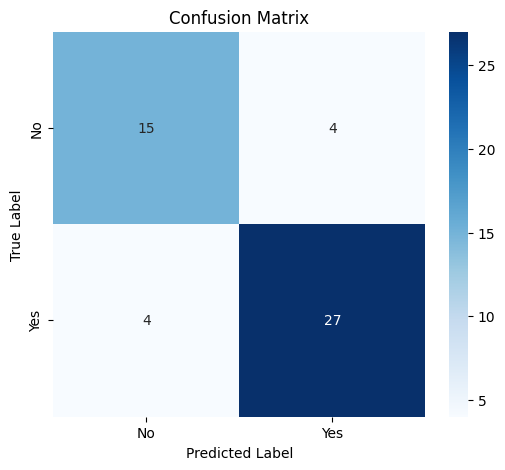

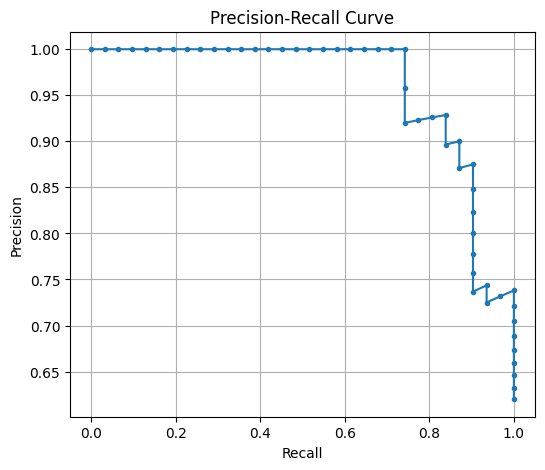


# Calibration Evaluation
Log Loss: 0.42515509944559504
Brier Loss: 0.13081718027812342


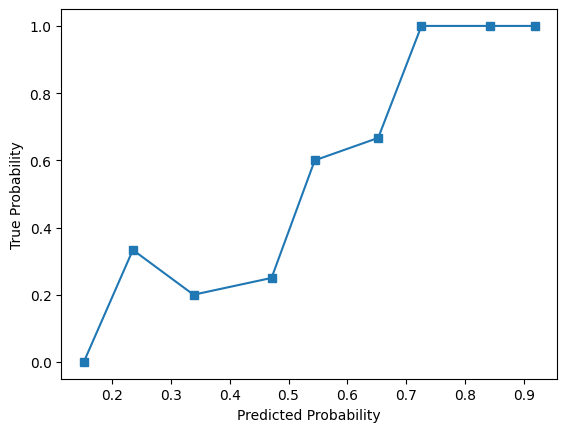

In [18]:
evaluate_model(val_labels, val_probs)

In [19]:
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

In [20]:
# Fit logistic regression for Platt Scaling
platt_scaler = LogisticRegression()
platt_scaler.fit(val_probs.reshape(-1, 1), val_labels)

# Get calibrated probabilities
platt_probs = platt_scaler.predict_proba(val_probs.reshape(-1, 1))[:, 1]

In [21]:
# Fit isotonic regression
iso_reg = IsotonicRegression(out_of_bounds="clip")  # Clip ensures values remain in valid probability range
iso_reg.fit(val_probs, val_labels)

# Get calibrated probabilities
iso_probs = iso_reg.predict(val_probs)

# Base Model Evaluation
Accuracy: 0.78
F1 Score: 0.835820895522388
Average Precision Score: 0.9601924702042719


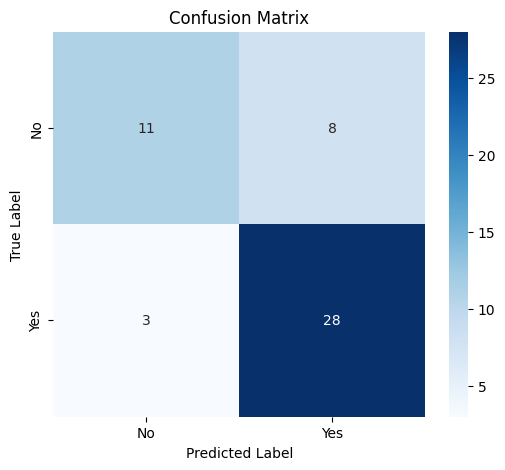

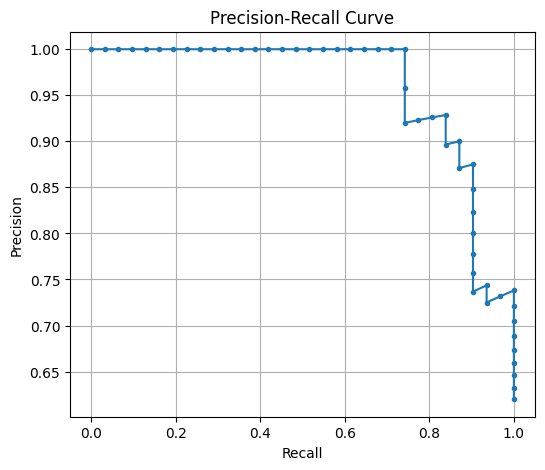


# Calibration Evaluation
Log Loss: 0.4995021181626133
Brier Loss: 0.1598425660315656


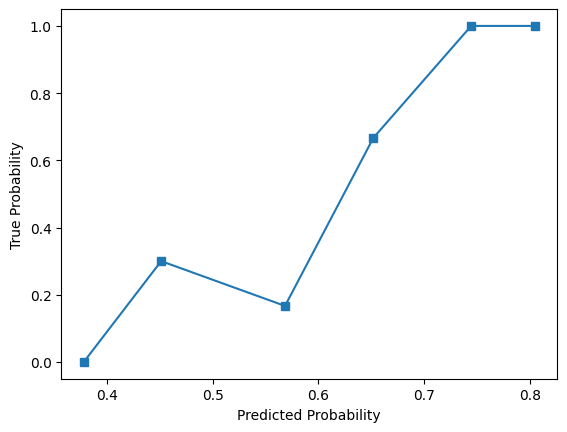

In [22]:
evaluate_model(val_labels, platt_probs)

# Base Model Evaluation
Accuracy: 0.86
F1 Score: 0.8813559322033898
Average Precision Score: 0.9596774193548387


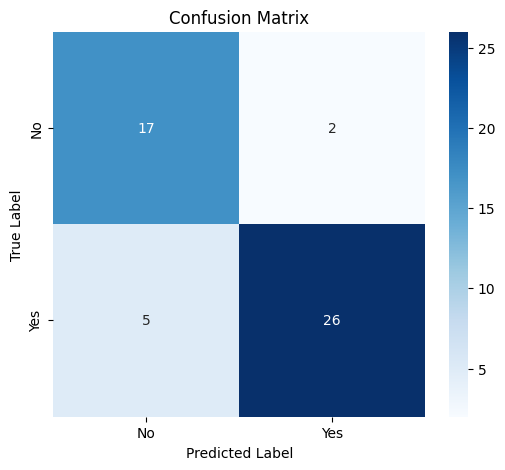

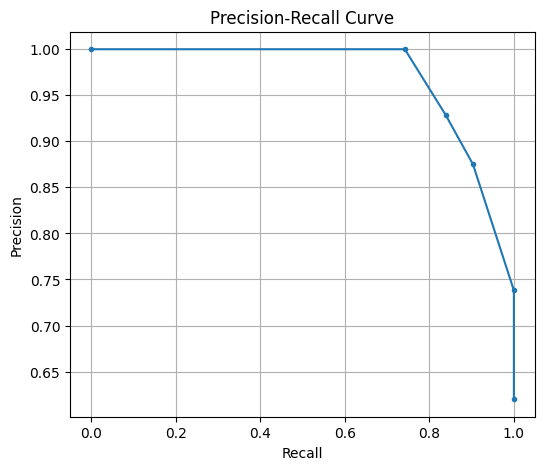


# Calibration Evaluation
Log Loss: 0.24492580155670007
Brier Loss: 0.086


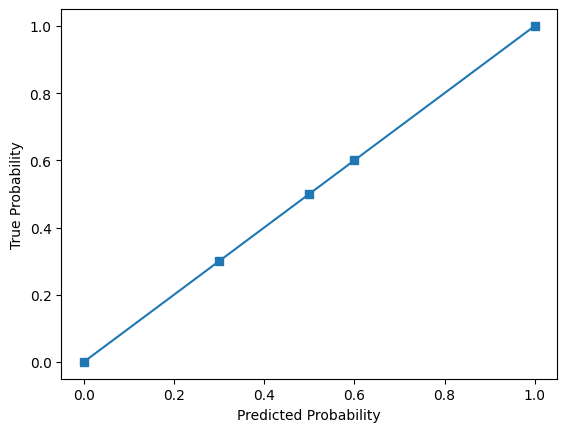

In [23]:
evaluate_model(val_labels, iso_probs)